In [3]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
import random
import numpy as np
import matplotlib.pyplot as plt
import model as VAE
%matplotlib inline

In [4]:
use_gpu = torch.cuda.is_available()
use_gpu

True

# Build Model

## Encoder Structure

In [13]:
class Encoder(nn.Module):
    def __init__(self, lstm_layer = 1, seq_len = 10, input_dim = 1, hidden_dim = 4, batch_size = 1):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_enc = nn.LSTM(input_dim, hidden_dim, lstm_layer, batch_first=True, bidirectional=True)
        self.fc_mu = nn.Linear(hidden_dim * 2, int(hidden_dim / 2))
        self.fc_logvar = nn.Linear(hidden_dim * 2, int(hidden_dim / 2))
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.seq_len = seq_len

    def encode(self, x):
        h1, _ = self.lstm_enc(x)
        h1 = self.tanh(h1)
        return self.fc_mu(h1[:, -1, :]), self.fc_logvar(h1[:, -1, :])

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            if use_gpu:
                eps = eps.cuda()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return mu, z

## Decoder structure

In [14]:
class Decoder(nn.Module):
    def __init__(self, lstm_layer = 1, seq_len = 10, input_dim = 1, hidden_dim = 4, batch_size = 1):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_dec = nn.LSTM(int(hidden_dim / 2), input_dim, lstm_layer, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * input_dim, input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.seq_len = seq_len

    def decode(self, z):
        z = z.view(z.shape[0], 1, -1)
        z = z.expand(-1, self.seq_len, -1)
        out, _ = self.lstm_dec(z)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out
    
    def forward(self, x):
        out = self.decode(x)
        return out

## VAE structure

In [15]:
class LSTMVAE(nn.Module):
    def __init__(self, lstm_layer = 1, seq_len = 10, input_dim = 1, hidden_dim = 2, batch_size = 1):
        super(LSTMVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, z = self.encoder(x)
        out = self.decoder(z)
        return out, mu, z

# Training

In [16]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss()(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (BCE, KLD)

In [17]:
def FakeSeqGen(seq=10, dim=1):
    weight = [1, 2, 1]
    initail_point = random.uniform(-100, 100)
    fake_seq = []
    interval = [0.1, 0.5, 1, 5, 10]
    for i in range(10):
        initail_point += i*0.1
        result = 0
        for j, w in enumerate(weight):
            result += w * (initail_point ** j)
        fake_seq.append(result + random.gauss(0, 1))
    return np.array(fake_seq).reshape(-1, 1)

## Random data generation

In [18]:
num_data = 100000
data = []
for _ in range(100000):
    data.append(FakeSeqGen())
data = np.array(data)
data = data/data.max()
data

array([[[0.04105841],
        [0.04079651],
        [0.03999486],
        ...,
        [0.03103859],
        [0.02836169],
        [0.02574877]],

       [[0.10019893],
        [0.10054296],
        [0.10201995],
        ...,
        [0.11740526],
        [0.12266787],
        [0.12860018]],

       [[0.0180863 ],
        [0.01810444],
        [0.01881037],
        ...,
        [0.02581566],
        [0.02832519],
        [0.03126066]],

       ...,

       [[0.51451863],
        [0.51338305],
        [0.51053361],
        ...,
        [0.47723305],
        [0.46689677],
        [0.45523449]],

       [[0.2000124 ],
        [0.19928728],
        [0.19754896],
        ...,
        [0.17691539],
        [0.17056242],
        [0.16369759]],

       [[0.06626308],
        [0.06659591],
        [0.06767916],
        ...,
        [0.08064832],
        [0.08490529],
        [0.08996775]]])

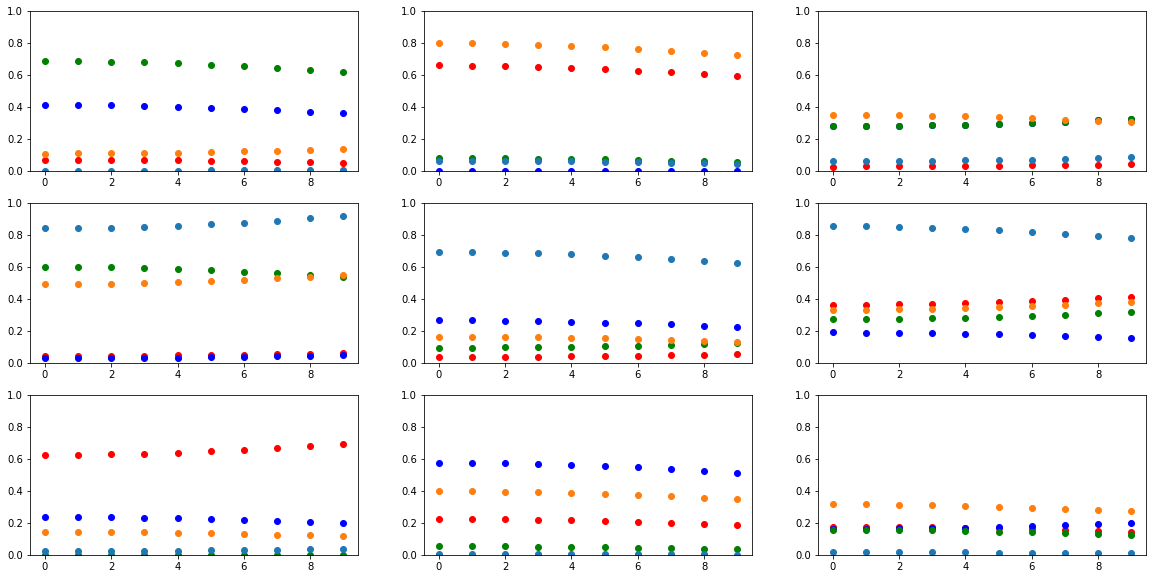

In [19]:
f, axs = plt.subplots(3, 3, figsize=(20, 10))
for _ in axs:
    for ax in _:
        ax.set_ylim([0, 1])
        ax.plot(range(10), data[random.randint(0, len(data))].flatten(), 'ro')
        ax.plot(range(10), data[random.randint(0, len(data))].flatten(), 'bo')
        ax.plot(range(10), data[random.randint(0, len(data))].flatten(), 'go')
        ax.plot(range(10), data[random.randint(0, len(data))].flatten(), 'o')
        ax.plot(range(10), data[random.randint(0, len(data))].flatten(), 'o')
plt.show()

In [20]:
def train(data, model, optimizer, num_epochs=8, batch_size=25):
    KLD_list = []
    MSE_list = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        KLD_loss = 0
        MSE_loss = 0
        total_size = len(data)
        data = data[torch.randperm(len(data)).cuda()]
        model.train()
        for batch in range(total_size // batch_size):
            if (batch+1) * batch_size > len(data):
                break
            optimizer.zero_grad()
            current_data = data[batch * batch_size : (batch+1) * batch_size]
            out, mu, z = model(current_data)
            MSE, KLD = loss_function(out, current_data, mu, z)

            loss = MSE + KLD
#             loss = MSE
            loss.backward()
            optimizer.step()
            KLD_loss += KLD.data[0]
            MSE_loss += MSE.data[0]
        KLD_list.append(KLD_loss)
        MSE_list.append(MSE_loss)
        print('KLD loss: {}'.format(KLD_loss))
        print('MSE loss: {}'.format(MSE_loss))
    return model, KLD_list, MSE_list

In [5]:
model = VAE.LSTMVAE()
if use_gpu:
    model.cuda()
optimizer = optim.Adam(model.parameters())

In [22]:
data = torch.FloatTensor(data)
if use_gpu:
    data = Variable(data).cuda()
else:
    data = Variable(data)
model, KLD, MSE = train(data, model, optimizer, num_epochs=100, batch_size=100)

Epoch 1/100
----------
KLD loss: 17802.88142848015
MSE loss: 92.33186814561486
Epoch 2/100
----------
KLD loss: 1124.748721510172
MSE loss: 72.9334678389132
Epoch 3/100
----------
KLD loss: 349.66636991500854
MSE loss: 72.73782478272915
Epoch 4/100
----------
KLD loss: 121.6754093170166
MSE loss: 72.63233215734363
Epoch 5/100
----------
KLD loss: 52.2827425301075
MSE loss: 72.56820137053728
Epoch 6/100
----------
KLD loss: 27.423921167850494
MSE loss: 72.52130522951484
Epoch 7/100
----------
KLD loss: 15.578029692173004
MSE loss: 72.49227790161967
Epoch 8/100
----------
KLD loss: 9.310534864664078
MSE loss: 72.46777580678463
Epoch 9/100
----------
KLD loss: 5.598057359457016
MSE loss: 72.44749190658331
Epoch 10/100
----------
KLD loss: 3.4636569917201996
MSE loss: 72.42767199873924
Epoch 11/100
----------
KLD loss: 2.1575652062892914
MSE loss: 72.39946331456304
Epoch 12/100
----------
KLD loss: 1.3588787019252777
MSE loss: 72.34340588748455
Epoch 13/100
----------
KLD loss: 0.922014385

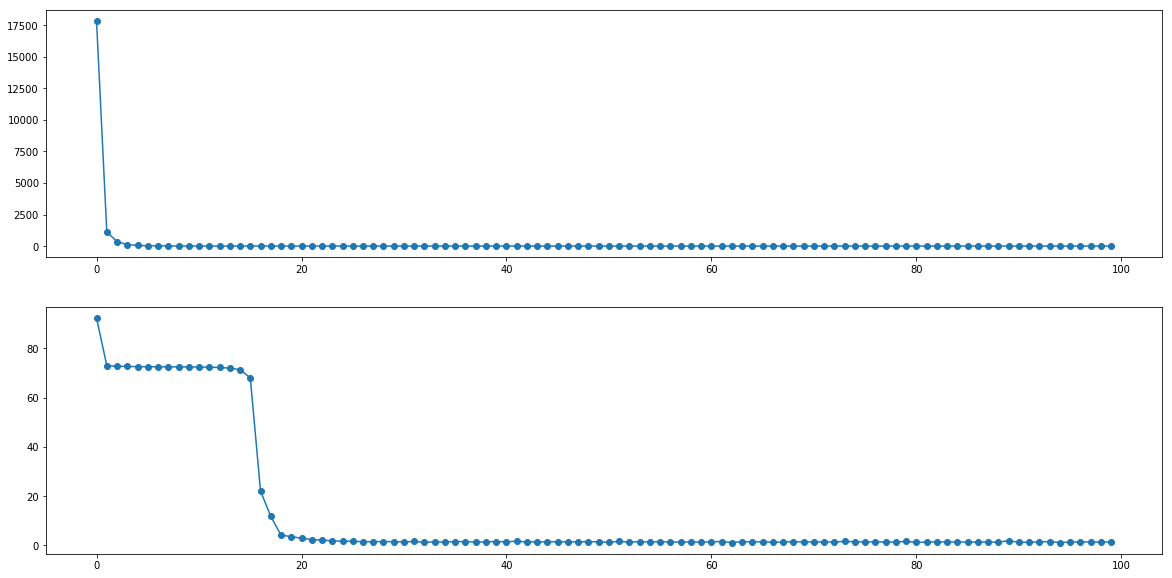

In [23]:
f, axs = plt.subplots(2, figsize=(20, 10))
axs[0].plot(range(100), KLD, linestyle='-', marker='o')
axs[1].plot(range(100), MSE, linestyle='-', marker='o')

## Test encoder

In [24]:
# test = data[0]
# if use_gpu:
#     test = Variable(data.cuda())
# else:
#     data = Variable(data)
model.eval()
mu, z = model.encoder(data[0].unsqueeze(0))
print(data[0])
print(z)

Variable containing:
1.00000e-02 *
  4.1058
  4.0797
  3.9995
  3.8937
  3.7323
  3.5682
  3.3490
  3.1039
  2.8362
  2.5749
[torch.cuda.FloatTensor of size 10x1 (GPU 0)]

Variable containing:
1.00000e-03 *
  2.1467 -2.9678
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]



## Test decoder

In [25]:
# z = torch.randn([1, 5])
# print(z)
# if use_gpu:
#     z = Variable(z.cuda())
# else:
#     z = Variable(z)
recover = model.decoder(z)
recover.squeeze()

Variable containing:
1.00000e-02 *
  2.8988
  3.0568
  3.1925
  3.2993
  3.3739
  3.4182
  3.4419
  3.4651
  3.5205
  3.6601
[torch.cuda.FloatTensor of size 10 (GPU 0)]

## Test some data

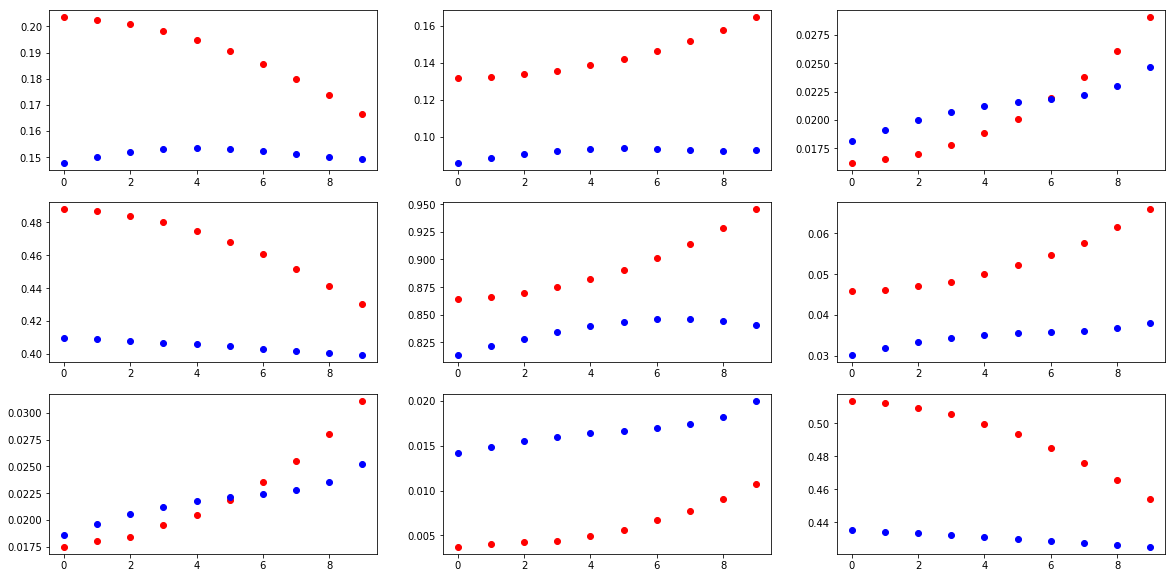

In [28]:
f, axs = plt.subplots(3, 3, figsize=(20, 10))
for _ in axs:
    for ax in _:
        model.eval()
        test_data = data[random.randint(0, len(data))]
        recon_x, _, _ = model(test_data.unsqueeze(0))
        recon_x = recon_x.data.squeeze().cpu().numpy()
#         ax.set_ylim([0, 1])
        ax.plot(range(10), test_data.data.squeeze().cpu().numpy(), 'ro')
        ax.plot(range(10), recon_x, 'bo')
plt.show()

# Draw the sample space

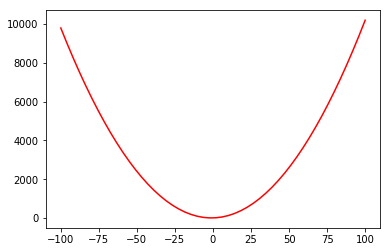

In [19]:
l = np.linspace(-100, 100)
w = [1, 2, 1]
expression = w[0] + w[1]*l + w[2]*l**2# + w[3]*l**3 + w[4]*l**4 + w[5]*l**5 + w[6]*l**6 + w[7]*l**7
plt.plot(l, expression, 'r')
plt.show()